# YoloV5 FaceDetector

## Sample Detection

In [23]:
from yolov5facedetector.face_detector import YoloDetector
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

model = YoloDetector(target_size=720,gpu=0,min_face=90)

# Load the image
rgb_array_img = np.array(Image.open('/Users/visakan/Desktop/Concordia University/Fall 24/COMP 6321 Machine Learning/Final Project/Code/Data/WIDER FACE Validation Set/images/9--Press_Conference/9_Press_Conference_Press_Conference_9_41.jpg'))  # RGB Numpy Array Image

# Predict using the model (assuming `model` is already initialized and loaded)
bboxes, confs, points = model.predict(rgb_array_img)
bboxes

[[[696, 186, 782, 295], [151, 186, 231, 290]]]

(-0.5, 1023.5, 683.5, -0.5)

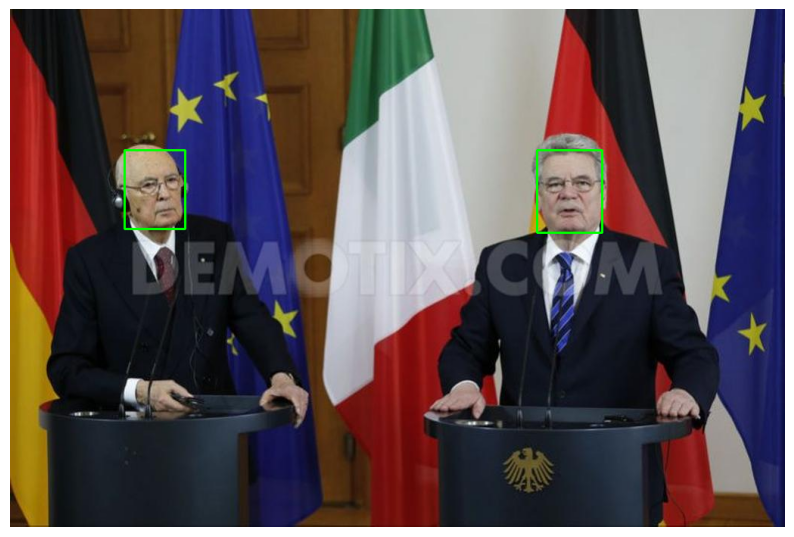

In [24]:
%matplotlib inline
# Create a copy of the image to draw on
visualized_img = rgb_array_img.copy()

# Convert to BGR format for OpenCV visualization
bgr_img = cv2.cvtColor(visualized_img, cv2.COLOR_RGB2BGR)

# Draw bounding boxes, confidence scores, and keypoints
for bbox_group, conf, point_set in zip(bboxes, confs, points):
    for bbox in bbox_group:  # Handle nested bounding boxes
        # Extract coordinates and confidence score
        x1, y1, x2, y2 = map(int, bbox)  # Bounding box coordinates
        confidence = conf               # Confidence score

        # Draw the bounding box
        cv2.rectangle(bgr_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Convert the image back to RGB for visualization in Matplotlib
visualized_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(visualized_img)
plt.axis('off')

## Defining Metrics

In [46]:
def calc_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = max(box1[2], box2[2])
    y2 = max(box1[3], box2[3])

    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    union = box1_area + box2_area - intersection

    if union == 0:
        return 0

    return intersection / union

def calc_precision(true_positives, false_positives):
    if true_positives + false_positives > 0:
        return true_positives / (true_positives + false_positives)
    else:
        return 0
    
def calc_recall(true_positives, false_negatives):
    if true_positives + false_negatives > 0:
        return true_positives / (true_positives + false_negatives)
    else:
        return 0
    
def calc_f1_score(precision, recall):
    if precision + recall > 0:
        return (2 * precision * recall) / (precision + recall)
    else:
        return 0
    
def evaluate_predictions(predictions, ground_truth, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    matched = [False] * len(ground_truth)

    for pred in predictions:
        matched_any = False
        for i, gt in enumerate(ground_truth):
            if not matched[i] and calc_iou(pred, gt) >= iou_threshold:
                matched[i] = True
                matched_any = True
                true_positives += 1
                break
        if not matched_any:
            false_positives += 1
    false_negatives = len(ground_truth) - sum(matched)

    precision = calc_precision(true_positives, false_positives)
    recall = calc_recall(true_positives, false_negatives)
    f1_score = calc_f1_score(precision, recall)

    return precision, recall, f1_score

## Evaluation Function

In [40]:
import json
import cv2
import numpy as np
from PIL import Image

def evaluate_yolo_with_predictions(json_path, output_path, predictions_output_path, yolo_model):
    """
    Evaluate YOLO model on a subset of images from the given JSON annotation file,
    and save the model's predictions in a separate JSON file.

    Args:
        json_path (str): Path to the JSON file containing annotations.
        output_path (str): Path to save the evaluation metrics as a JSON file.
        predictions_output_path (str): Path to save the model predictions as a JSON file.
        yolo_model (YoloDetector): Initialized YOLO face detection model.

    Returns:
        None: Prints mean precision, recall, and F1-score, saves metrics and predictions to JSON files.
    """
    # Load the annotations
    with open(json_path, 'r') as json_file:
        annotations = json.load(json_file)

    # Metrics for all images
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Store predictions
    predictions_data = []

    for index, image_annotation in enumerate(annotations):
        # Track progress
        print(f"Processing image ({index + 1}/{len(annotations)}) ...")

        # Convert ground truths to bbox format (x, y, x+w, y+h)
        ground_truths = [
            [int(gt['bbox'][0]), int(gt['bbox'][1]), int(gt['bbox'][0] + gt['bbox'][2]), int(gt['bbox'][1] + gt['bbox'][3])]
            for gt in image_annotation['image_info']
        ]

        # Load the image
        image_path = image_annotation['image_path']
        image = np.array(Image.open(image_path))  # Load image as RGB array
        if image is None:
            print(f"Error: Could not load image at {image_path}")
            continue

        # Get predictions using YOLO model
        bboxes, confs, points = yolo_model.predict(image)
        predictions = []
        for bbox_group in bboxes:
            for bbox in bbox_group:
                # Ensure bbox is in integer format
                x1, y1, x2, y2 = map(int, bbox)
                predictions.append([x1, y1, x2, y2])

        # Save predictions for this image
        predictions_data.append({
            "image_path": image_path,
            "predicted_boxes": predictions
        })

        # Calculate metrics
        precision, recall, f1_score = evaluate_predictions(predictions, ground_truths)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1_score)

    # Calculate mean metrics
    mean_precision = sum(precision_scores) / len(precision_scores) if precision_scores else 0
    mean_recall = sum(recall_scores) / len(recall_scores) if recall_scores else 0
    mean_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0

    # Print the results
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1-Score: {mean_f1:.4f}")

    # Save metrics to a JSON file
    output_data = {
        "mean_precision": mean_precision,
        "mean_recall": mean_recall,
        "mean_f1_score": mean_f1,
        "individual_scores": {
            "precision_scores": [float(p) for p in precision_scores],  # Convert to float
            "recall_scores": [float(r) for r in recall_scores],        # Convert to float
            "f1_scores": [float(f) for f in f1_scores]                # Convert to float
        }
    }
    with open(output_path, 'w') as output_file:
        json.dump(output_data, output_file, indent=4)
    print(f"Metrics saved to {output_path}")

    # Save predictions to a separate JSON file
    with open(predictions_output_path, 'w') as pred_file:
        json.dump(predictions_data, pred_file, indent=4)
    print(f"Predictions saved to {predictions_output_path}")

In [41]:
import random

def evaluate_yolo_with_random_subset(json_path, output_path, predictions_output_path, yolo_model, num_samples=None, seed=42):
    """
    Evaluate YOLO model on a randomly chosen subset of images from the given JSON annotation file,
    and save the model's predictions in a separate JSON file.

    Args:
        json_path (str): Path to the JSON file containing annotations.
        output_path (str): Path to save the evaluation metrics as a JSON file.
        predictions_output_path (str): Path to save the model predictions as a JSON file.
        yolo_model (YoloDetector): Initialized YOLO face detection model.
        num_samples (int, optional): Number of random entries to use from the dataset. If None, use the entire dataset.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        None: Prints mean precision, recall, and F1-score, saves metrics and predictions to JSON files.
    """
    # Load the annotations
    with open(json_path, 'r') as json_file:
        annotations = json.load(json_file)

    # Randomly sample the dataset if num_samples is specified
    if num_samples is not None:
        random.seed(seed)
        annotations = random.sample(annotations, min(num_samples, len(annotations)))

    # Metrics for all images
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Store predictions
    predictions_data = []

    for index, image_annotation in enumerate(annotations):
        # Track progress
        print(f"Processing image ({index + 1}/{len(annotations)}) ...")

        # Convert ground truths to bbox format (x, y, x+w, y+h)
        ground_truths = [
            [int(gt['bbox'][0]), int(gt['bbox'][1]), int(gt['bbox'][0] + gt['bbox'][2]), int(gt['bbox'][1] + gt['bbox'][3])]
            for gt in image_annotation['image_info']
        ]

        # Load the image
        image_path = image_annotation['image_path']
        image = np.array(Image.open(image_path))  # Load image as RGB array
        if image is None:
            print(f"Error: Could not load image at {image_path}")
            continue

        # Get predictions using YOLO model
        bboxes, confs, points = yolo_model.predict(image)
        predictions = []
        for bbox_group in bboxes:
            for bbox in bbox_group:
                # Ensure bbox is in integer format
                x1, y1, x2, y2 = map(int, bbox)
                predictions.append([x1, y1, x2, y2])

        # Save predictions for this image
        predictions_data.append({
            "image_path": image_path,
            "predicted_boxes": predictions
        })

        # Calculate metrics
        precision, recall, f1_score = evaluate_predictions(predictions, ground_truths)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1_score)

    # Calculate mean metrics
    mean_precision = sum(precision_scores) / len(precision_scores) if precision_scores else 0
    mean_recall = sum(recall_scores) / len(recall_scores) if recall_scores else 0
    mean_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0

    # Print the results
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1-Score: {mean_f1:.4f}")

    # Save metrics to a JSON file
    output_data = {
        "mean_precision": mean_precision,
        "mean_recall": mean_recall,
        "mean_f1_score": mean_f1,
        "individual_scores": {
            "precision_scores": [float(p) for p in precision_scores],  # Convert to float
            "recall_scores": [float(r) for r in recall_scores],        # Convert to float
            "f1_scores": [float(f) for f in f1_scores]                # Convert to float
        }
    }
    with open(output_path, 'w') as output_file:
        json.dump(output_data, output_file, indent=4)
    print(f"Metrics saved to {output_path}")

    # Save predictions to a separate JSON file
    with open(predictions_output_path, 'w') as pred_file:
        json.dump(predictions_data, pred_file, indent=4)
    print(f"Predictions saved to {predictions_output_path}")

In [2]:
from yolov5facedetector.face_detector import YoloDetector

yolo_model = YoloDetector(target_size=720, gpu=0, min_face=30)

/Users/visakan/anaconda3/envs/yolov5_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
json_path = "Data/WIDER FACE Validation Set/wider_face_num_faces_easy.json"
output_path = "Outputs YOLOv5/test.json"
predictions_output_path = "Outputs YOLOv5/test_pred.json"

evaluate_yolo_with_random_subset(json_path, output_path, predictions_output_path, yolo_model, 10)

Processing image (1/10) ...
Processing image (2/10) ...
Processing image (3/10) ...
Processing image (4/10) ...
Processing image (5/10) ...
Processing image (6/10) ...
Processing image (7/10) ...
Processing image (8/10) ...
Processing image (9/10) ...
Processing image (10/10) ...
Mean Precision: 0.9000
Mean Recall: 1.0000
Mean F1-Score: 0.9333
Metrics saved to Outputs YOLOv5/test.json
Predictions saved to Outputs YOLOv5/test_pred.json


## Computing for WIDERFACE Dataset on the Number of Faces

### Easy Number of Faces

In [42]:
json_path = "Data/WIDER FACE Validation Set/wider_face_num_faces_easy.json"
output_path = "Outputs YOLOv5/metrics_easy_num_faces.json"
predictions_output_path = "Outputs YOLOv5/predictions_easy_num_faces.json"

evaluate_yolo_with_predictions(json_path, output_path, predictions_output_path, yolo_model)

Processing image (1/1122) ...
Processing image (2/1122) ...
Processing image (3/1122) ...
Processing image (4/1122) ...
Processing image (5/1122) ...
Processing image (6/1122) ...
Processing image (7/1122) ...
Processing image (8/1122) ...
Processing image (9/1122) ...
Processing image (10/1122) ...
Processing image (11/1122) ...
Processing image (12/1122) ...
Processing image (13/1122) ...
Processing image (14/1122) ...
Processing image (15/1122) ...
Processing image (16/1122) ...
Processing image (17/1122) ...
Processing image (18/1122) ...
Processing image (19/1122) ...
Processing image (20/1122) ...
Processing image (21/1122) ...
Processing image (22/1122) ...
Processing image (23/1122) ...
Processing image (24/1122) ...
Processing image (25/1122) ...
Processing image (26/1122) ...
Processing image (27/1122) ...
Processing image (28/1122) ...
Processing image (29/1122) ...
Processing image (30/1122) ...
Processing image (31/1122) ...
Processing image (32/1122) ...
Processing image 

### Medium Number of Faces

In [44]:
json_path = "Data/WIDER FACE Validation Set/wider_face_num_faces_medium.json"
output_path = "Outputs YOLOv5/metrics_medium_num_faces.json"
predictions_output_path = "Outputs YOLOv5/predictions_medium_num_faces.json"

evaluate_yolo_with_predictions(json_path, output_path, predictions_output_path, yolo_model)

Processing image (1/1089) ...
Processing image (2/1089) ...
Processing image (3/1089) ...
Processing image (4/1089) ...
Processing image (5/1089) ...
Processing image (6/1089) ...
Processing image (7/1089) ...
Processing image (8/1089) ...
Processing image (9/1089) ...
Processing image (10/1089) ...
Processing image (11/1089) ...
Processing image (12/1089) ...
Processing image (13/1089) ...
Processing image (14/1089) ...
Processing image (15/1089) ...
Processing image (16/1089) ...
Processing image (17/1089) ...
Processing image (18/1089) ...
Processing image (19/1089) ...
Processing image (20/1089) ...
Processing image (21/1089) ...
Processing image (22/1089) ...
Processing image (23/1089) ...
Processing image (24/1089) ...
Processing image (25/1089) ...
Processing image (26/1089) ...
Processing image (27/1089) ...
Processing image (28/1089) ...
Processing image (29/1089) ...
Processing image (30/1089) ...
Processing image (31/1089) ...
Processing image (32/1089) ...
Processing image 

### Hard Number of Faces

In [47]:
json_path = "Data/WIDER FACE Validation Set/wider_face_num_faces_hard.json"
output_path = "Outputs YOLOv5/metrics_hard_num_faces.json"
predictions_output_path = "Outputs YOLOv5/predictions_hard_num_faces.json"

evaluate_yolo_with_predictions(json_path, output_path, predictions_output_path, yolo_model)

Processing image (1/1015) ...
Processing image (2/1015) ...
Processing image (3/1015) ...
Processing image (4/1015) ...
Processing image (5/1015) ...
Processing image (6/1015) ...
Processing image (7/1015) ...
Processing image (8/1015) ...
Processing image (9/1015) ...
Processing image (10/1015) ...
Processing image (11/1015) ...
Processing image (12/1015) ...
Processing image (13/1015) ...
Processing image (14/1015) ...
Processing image (15/1015) ...
Processing image (16/1015) ...
Processing image (17/1015) ...
Processing image (18/1015) ...
Processing image (19/1015) ...
Processing image (20/1015) ...
Processing image (21/1015) ...
Processing image (22/1015) ...
Processing image (23/1015) ...
Processing image (24/1015) ...
Processing image (25/1015) ...
Processing image (26/1015) ...
Processing image (27/1015) ...
Processing image (28/1015) ...
Processing image (29/1015) ...
Processing image (30/1015) ...
Processing image (31/1015) ...
Processing image (32/1015) ...
Processing image 

## Computing for WIDERFACE Dataset on Blur

### Blur = 0

In [48]:
json_path = "Data/WIDER FACE Validation Set/wider_face_easy_blur.json"
output_path = "Outputs YOLOv5/metrics_easy_blur.json"
predictions_output_path = "Outputs YOLOv5/predictions_easy_blur.json"

evaluate_yolo_with_random_subset(json_path, output_path, predictions_output_path, yolo_model, 700)

Processing image (1/700) ...
Processing image (2/700) ...
Processing image (3/700) ...
Processing image (4/700) ...
Processing image (5/700) ...
Processing image (6/700) ...
Processing image (7/700) ...
Processing image (8/700) ...
Processing image (9/700) ...
Processing image (10/700) ...
Processing image (11/700) ...
Processing image (12/700) ...
Processing image (13/700) ...
Processing image (14/700) ...
Processing image (15/700) ...
Processing image (16/700) ...
Processing image (17/700) ...
Processing image (18/700) ...
Processing image (19/700) ...
Processing image (20/700) ...
Processing image (21/700) ...
Processing image (22/700) ...
Processing image (23/700) ...
Processing image (24/700) ...
Processing image (25/700) ...
Processing image (26/700) ...
Processing image (27/700) ...
Processing image (28/700) ...
Processing image (29/700) ...
Processing image (30/700) ...
Processing image (31/700) ...
Processing image (32/700) ...
Processing image (33/700) ...
Processing image (3

In [49]:
json_path = "Data/WIDER FACE Validation Set/wider_face_medium_blur.json"
output_path = "Outputs YOLOv5/metrics_medium_blur.json"
predictions_output_path = "Outputs YOLOv5/predictions_medium_blur.json"

evaluate_yolo_with_random_subset(json_path, output_path, predictions_output_path, yolo_model, 700)

Processing image (1/700) ...
Processing image (2/700) ...
Processing image (3/700) ...
Processing image (4/700) ...
Processing image (5/700) ...
Processing image (6/700) ...
Processing image (7/700) ...
Processing image (8/700) ...
Processing image (9/700) ...
Processing image (10/700) ...
Processing image (11/700) ...
Processing image (12/700) ...
Processing image (13/700) ...
Processing image (14/700) ...
Processing image (15/700) ...
Processing image (16/700) ...
Processing image (17/700) ...
Processing image (18/700) ...
Processing image (19/700) ...
Processing image (20/700) ...
Processing image (21/700) ...
Processing image (22/700) ...
Processing image (23/700) ...
Processing image (24/700) ...
Processing image (25/700) ...
Processing image (26/700) ...
Processing image (27/700) ...
Processing image (28/700) ...
Processing image (29/700) ...
Processing image (30/700) ...
Processing image (31/700) ...
Processing image (32/700) ...
Processing image (33/700) ...
Processing image (3

In [50]:
json_path = "Data/WIDER FACE Validation Set/wider_face_hard_blur.json"
output_path = "Outputs YOLOv5/metrics_hard_blur.json"
predictions_output_path = "Outputs YOLOv5/predictions_hard_blur.json"

evaluate_yolo_with_random_subset(json_path, output_path, predictions_output_path, yolo_model, 700)

Processing image (1/700) ...
Processing image (2/700) ...
Processing image (3/700) ...
Processing image (4/700) ...
Processing image (5/700) ...
Processing image (6/700) ...
Processing image (7/700) ...
Processing image (8/700) ...
Processing image (9/700) ...
Processing image (10/700) ...
Processing image (11/700) ...
Processing image (12/700) ...
Processing image (13/700) ...
Processing image (14/700) ...
Processing image (15/700) ...
Processing image (16/700) ...
Processing image (17/700) ...
Processing image (18/700) ...
Processing image (19/700) ...
Processing image (20/700) ...
Processing image (21/700) ...
Processing image (22/700) ...
Processing image (23/700) ...
Processing image (24/700) ...
Processing image (25/700) ...
Processing image (26/700) ...
Processing image (27/700) ...
Processing image (28/700) ...
Processing image (29/700) ...
Processing image (30/700) ...
Processing image (31/700) ...
Processing image (32/700) ...
Processing image (33/700) ...
Processing image (3

## Computing for WIDERFACE Dataset on Occlusion

### Occlusion = 0

In [51]:
json_path = "Data/WIDER FACE Validation Set/wider_face_easy_occlusion.json"
output_path = "Outputs YOLOv5/metrics_easy_occlusion.json"
predictions_output_path = "Outputs YOLOv5/predictions_easy_occlusion.json"

evaluate_yolo_with_random_subset(json_path, output_path, predictions_output_path, yolo_model, 300)

Processing image (1/300) ...
Processing image (2/300) ...
Processing image (3/300) ...
Processing image (4/300) ...
Processing image (5/300) ...
Processing image (6/300) ...
Processing image (7/300) ...
Processing image (8/300) ...
Processing image (9/300) ...
Processing image (10/300) ...
Processing image (11/300) ...
Processing image (12/300) ...
Processing image (13/300) ...
Processing image (14/300) ...
Processing image (15/300) ...
Processing image (16/300) ...
Processing image (17/300) ...
Processing image (18/300) ...
Processing image (19/300) ...
Processing image (20/300) ...
Processing image (21/300) ...
Processing image (22/300) ...
Processing image (23/300) ...
Processing image (24/300) ...
Processing image (25/300) ...
Processing image (26/300) ...
Processing image (27/300) ...
Processing image (28/300) ...
Processing image (29/300) ...
Processing image (30/300) ...
Processing image (31/300) ...
Processing image (32/300) ...
Processing image (33/300) ...
Processing image (3

In [52]:
json_path = "Data/WIDER FACE Validation Set/wider_face_medium_occlusion.json"
output_path = "Outputs YOLOv5/metrics_medium_occlusion.json"
predictions_output_path = "Outputs YOLOv5/predictions_medium_occlusion.json"

evaluate_yolo_with_random_subset(json_path, output_path, predictions_output_path, yolo_model, 300)

Processing image (1/300) ...
Processing image (2/300) ...
Processing image (3/300) ...
Processing image (4/300) ...
Processing image (5/300) ...
Processing image (6/300) ...
Processing image (7/300) ...
Processing image (8/300) ...
Processing image (9/300) ...
Processing image (10/300) ...
Processing image (11/300) ...
Processing image (12/300) ...
Processing image (13/300) ...
Processing image (14/300) ...
Processing image (15/300) ...
Processing image (16/300) ...
Processing image (17/300) ...
Processing image (18/300) ...
Processing image (19/300) ...
Processing image (20/300) ...
Processing image (21/300) ...
Processing image (22/300) ...
Processing image (23/300) ...
Processing image (24/300) ...
Processing image (25/300) ...
Processing image (26/300) ...
Processing image (27/300) ...
Processing image (28/300) ...
Processing image (29/300) ...
Processing image (30/300) ...
Processing image (31/300) ...
Processing image (32/300) ...
Processing image (33/300) ...
Processing image (3

In [53]:
json_path = "Data/WIDER FACE Validation Set/wider_face_hard_occlusion.json"
output_path = "Outputs YOLOv5/metrics_hard_occlusion.json"
predictions_output_path = "Outputs YOLOv5/predictions_hard_occlusion.json"

evaluate_yolo_with_random_subset(json_path, output_path, predictions_output_path, yolo_model, 300)

Processing image (1/300) ...
Processing image (2/300) ...
Processing image (3/300) ...
Processing image (4/300) ...
Processing image (5/300) ...
Processing image (6/300) ...
Processing image (7/300) ...
Processing image (8/300) ...
Processing image (9/300) ...
Processing image (10/300) ...
Processing image (11/300) ...
Processing image (12/300) ...
Processing image (13/300) ...
Processing image (14/300) ...
Processing image (15/300) ...
Processing image (16/300) ...
Processing image (17/300) ...
Processing image (18/300) ...
Processing image (19/300) ...
Processing image (20/300) ...
Processing image (21/300) ...
Processing image (22/300) ...
Processing image (23/300) ...
Processing image (24/300) ...
Processing image (25/300) ...
Processing image (26/300) ...
Processing image (27/300) ...
Processing image (28/300) ...
Processing image (29/300) ...
Processing image (30/300) ...
Processing image (31/300) ...
Processing image (32/300) ...
Processing image (33/300) ...
Processing image (3

## Computing for WIDERFACE Dataset on Illumination

### Illumination = 0

In [54]:
json_path = "Data/WIDER FACE Validation Set/wider_face_normal_illumination.json"
output_path = "Outputs YOLOv5/metrics_normal_illumination.json"
predictions_output_path = "Outputs YOLOv5/predictions_normal_illumination.json"

evaluate_yolo_with_random_subset(json_path, output_path, predictions_output_path, yolo_model, 400)

Processing image (1/400) ...
Processing image (2/400) ...
Processing image (3/400) ...
Processing image (4/400) ...
Processing image (5/400) ...
Processing image (6/400) ...
Processing image (7/400) ...
Processing image (8/400) ...
Processing image (9/400) ...
Processing image (10/400) ...
Processing image (11/400) ...
Processing image (12/400) ...
Processing image (13/400) ...
Processing image (14/400) ...
Processing image (15/400) ...
Processing image (16/400) ...
Processing image (17/400) ...
Processing image (18/400) ...
Processing image (19/400) ...
Processing image (20/400) ...
Processing image (21/400) ...
Processing image (22/400) ...
Processing image (23/400) ...
Processing image (24/400) ...
Processing image (25/400) ...
Processing image (26/400) ...
Processing image (27/400) ...
Processing image (28/400) ...
Processing image (29/400) ...
Processing image (30/400) ...
Processing image (31/400) ...
Processing image (32/400) ...
Processing image (33/400) ...
Processing image (3

### illumination = 1

In [55]:
json_path = "Data/WIDER FACE Validation Set/wider_face_extreme_illumination.json"
output_path = "Outputs YOLOv5/metrics_extreme_illumination.json"
predictions_output_path = "Outputs YOLOv5/predictions_extreme_illumination.json"

evaluate_yolo_with_random_subset(json_path, output_path, predictions_output_path, yolo_model, 400)

Processing image (1/400) ...
Processing image (2/400) ...
Processing image (3/400) ...
Processing image (4/400) ...
Processing image (5/400) ...
Processing image (6/400) ...
Processing image (7/400) ...
Processing image (8/400) ...
Processing image (9/400) ...
Processing image (10/400) ...
Processing image (11/400) ...
Processing image (12/400) ...
Processing image (13/400) ...
Processing image (14/400) ...
Processing image (15/400) ...
Processing image (16/400) ...
Processing image (17/400) ...
Processing image (18/400) ...
Processing image (19/400) ...
Processing image (20/400) ...
Processing image (21/400) ...
Processing image (22/400) ...
Processing image (23/400) ...
Processing image (24/400) ...
Processing image (25/400) ...
Processing image (26/400) ...
Processing image (27/400) ...
Processing image (28/400) ...
Processing image (29/400) ...
Processing image (30/400) ...
Processing image (31/400) ...
Processing image (32/400) ...
Processing image (33/400) ...
Processing image (3

## Precision - Recall Curve

In [ ]:
import json
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def precision_recall_curve_random_yolo(json_path, iou_thresholds, yolo_model, max_images, output_path, seed=42):
    """
    Generate a precision-recall curve for YOLO model on a randomly chosen subset of images and save the scores.

    Args:
        json_path (str): Path to the JSON file containing annotations.
        iou_thresholds (list): List of IoU thresholds to evaluate.
        yolo_model (YoloDetector): Initialized YOLO face detection model.
        max_images (int): Number of images to process.
        output_path (str): Path to save the precision-recall scores as a JSON file.
        seed (int): Random seed for reproducibility.

    Returns:
        None: Prints and saves the precision-recall scores, and plots the curve.
    """
    # Load the annotations
    with open(json_path, 'r') as json_file:
        annotations = json.load(json_file)

    # Randomly select a subset of the data
    random.seed(seed)
    if len(annotations) > max_images:
        annotations_subset = random.sample(annotations, max_images)
    else:
        annotations_subset = annotations
        print(f"Warning: Dataset contains fewer than {max_images} images. Using all available images.")

    # Store metrics for each IoU threshold
    scores = {"iou_thresholds": [], "precision": [], "recall": []}

    # Evaluate for each IoU threshold
    for iou_threshold in iou_thresholds:
        print(f"Evaluating for IoU threshold: {iou_threshold:.2f}")

        true_positives = 0
        false_positives = 0
        false_negatives = 0

        for image_annotation in annotations_subset:
            # Convert ground truths to bbox format (x, y, x+w, y+h)
            ground_truths = [
                [int(gt['bbox'][0]), int(gt['bbox'][1]), int(gt['bbox'][0] + gt['bbox'][2]), int(gt['bbox'][1] + gt['bbox'][3])]
                for gt in image_annotation['image_info']
            ]

            # Load the image
            image_path = image_annotation['image_path']
            image = np.array(Image.open(image_path))  # Load image as RGB array
            if image is None:
                print(f"Error: Could not load image at {image_path}")
                continue

            # Get predictions using YOLO model
            bboxes, confs, points = yolo_model.predict(image)
            predictions = []
            for bbox_group in bboxes:
                for bbox in bbox_group:
                    # Ensure bbox is in integer format
                    x1, y1, x2, y2 = map(int, bbox)
                    predictions.append([x1, y1, x2, y2])

            # Match predictions with ground truths using IoU
            matched_gt = [False] * len(ground_truths)
            for pred in predictions:
                matched = False
                for i, gt in enumerate(ground_truths):
                    if not matched_gt[i] and calc_iou(pred, gt) >= iou_threshold:
                        matched_gt[i] = True
                        matched = True
                        true_positives += 1
                        break
                if not matched:
                    false_positives += 1

            false_negatives += sum(1 for match in matched_gt if not match)

        # Calculate precision and recall
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

        # Store scores
        scores["iou_thresholds"].append(iou_threshold)
        scores["precision"].append(precision)
        scores["recall"].append(recall)

    # Save scores to JSON
    with open(output_path, 'w') as output_file:
        json.dump(scores, output_file, indent=4)
    print(f"Precision-Recall scores saved to {output_path}")

Evaluating for IoU threshold: 0.10
Evaluating for IoU threshold: 0.20
Evaluating for IoU threshold: 0.30
Evaluating for IoU threshold: 0.40
Evaluating for IoU threshold: 0.50
Evaluating for IoU threshold: 0.60
Evaluating for IoU threshold: 0.70
Evaluating for IoU threshold: 0.80
Evaluating for IoU threshold: 0.90
Precision-Recall scores saved to Outputs YOLOv5/precision_recall_scores.json


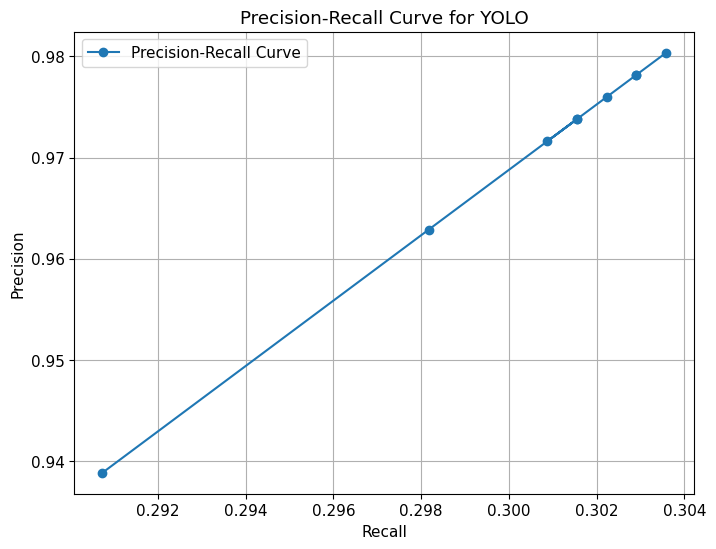

In [60]:
json_path = "Data/WIDER FACE Validation Set/wider_face_val_annotations.json"
iou_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
output_path = "Outputs YOLOv5/precision_recall_scores.json"

precision_recall_curve_random_yolo(json_path, iou_thresholds, yolo_model, 100, output_path)

## Inference Time

In [ ]:
import random
import time
import json
import numpy as np
from PIL import Image

def calculate_average_yolo_prediction_time(json_path, yolo_model, num_samples=100, seed=42):
    """
    Calculate the average prediction time for a YOLO model by testing it on a random subset of images.

    Args:
        json_path (str): Path to the JSON file containing annotations.
        yolo_model (YoloDetector): Initialized YOLO face detection model.
        num_samples (int, optional): Number of random entries to test. Default is 100.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        float: The average prediction time per image in seconds.
    """

    with open(json_path, 'r') as json_file:
        annotations = json.load(json_file)

    random.seed(seed)
    sampled_annotations = random.sample(annotations, min(num_samples, len(annotations)))

    prediction_times = []

    for index, image_annotation in enumerate(sampled_annotations):
        print(f"Processing image ({index + 1}/{len(sampled_annotations)}) ...")

        image_path = image_annotation['image_path']
        image = np.array(Image.open(image_path)) 
        if image is None:
            print(f"Error: Could not load image at {image_path}")
            continue

        start_time = time.time()

        _ = yolo_model.predict(image)

        end_time = time.time()

        prediction_time = end_time - start_time
        prediction_times.append(prediction_time)

    if prediction_times:
        average_time = sum(prediction_times) / len(prediction_times)
        print(f"Average prediction time: {average_time:.4f} seconds per image")
        return average_time
    else:
        print("No valid images were processed.")
        return None

In [4]:
json_path = "Data/WIDER FACE Validation Set/wider_face_val_annotations.json"

calculate_average_yolo_prediction_time(json_path, yolo_model)

Processing image (1/100) ...
Processing image (2/100) ...
Processing image (3/100) ...
Processing image (4/100) ...
Processing image (5/100) ...
Processing image (6/100) ...
Processing image (7/100) ...
Processing image (8/100) ...
Processing image (9/100) ...
Processing image (10/100) ...
Processing image (11/100) ...
Processing image (12/100) ...
Processing image (13/100) ...
Processing image (14/100) ...
Processing image (15/100) ...
Processing image (16/100) ...
Processing image (17/100) ...
Processing image (18/100) ...
Processing image (19/100) ...
Processing image (20/100) ...
Processing image (21/100) ...
Processing image (22/100) ...
Processing image (23/100) ...
Processing image (24/100) ...
Processing image (25/100) ...
Processing image (26/100) ...
Processing image (27/100) ...
Processing image (28/100) ...
Processing image (29/100) ...
Processing image (30/100) ...
Processing image (31/100) ...
Processing image (32/100) ...
Processing image (33/100) ...
Processing image (3

0.170702543258667